# MLflow Lab: California Housing Price Prediction

This notebook demonstrates MLOps practices using MLflow for tracking experiments, model versioning, and deployment for California Housing dataset

### Prerequisites

In [1]:
!pip install mlflow scikit-learn xgboost hyperopt pandas numpy seaborn matplotlib pyspark ipykernel

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import sklearn
import time
import warnings
warnings.filterwarnings('ignore')

### Step 1: Load and Prepare Data

In [3]:
housing = fetch_california_housing(as_frame=True)
data = housing.frame

print(f"Dataset shape: {data.shape}")
print(f"Features: {list(housing.feature_names)}")
print(f"Target: {housing.target_names[0]}")

Dataset shape: (20640, 9)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: MedHouseVal


### Step 2: Display data

In [4]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Step 3: Data Exploration

In [5]:
print(data.describe())
print(f"\nMissing values: {data.isnull().sum().sum()}")

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

### Step 4: Data Visualization

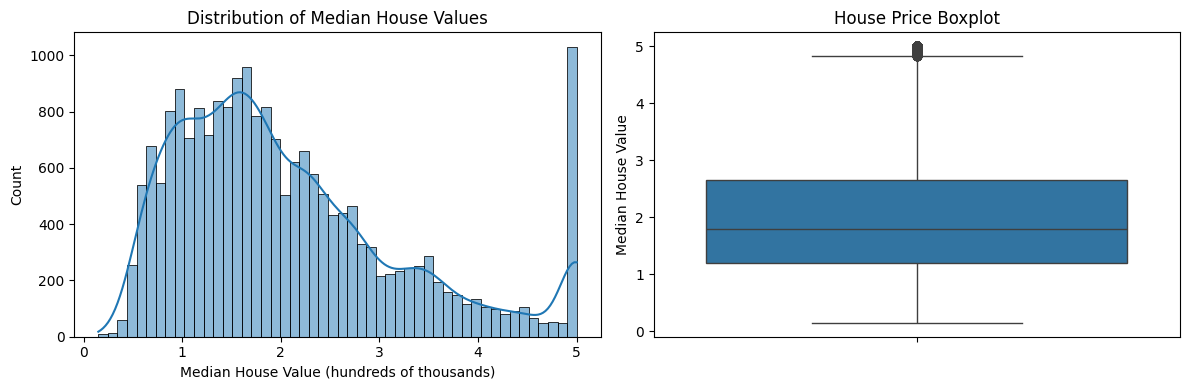

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data.MedHouseVal, kde=True, bins=50)
plt.title('Distribution of Median House Values')
plt.xlabel('Median House Value (hundreds of thousands)')

plt.subplot(1, 2, 2)
sns.boxplot(y=data.MedHouseVal)
plt.title('House Price Boxplot')
plt.ylabel('Median House Value')
plt.tight_layout()
plt.show()

### Step 5: Define Price Categories 

High value houses: 2652 (12.8%)
Regular value houses: 17988 (87.2%)


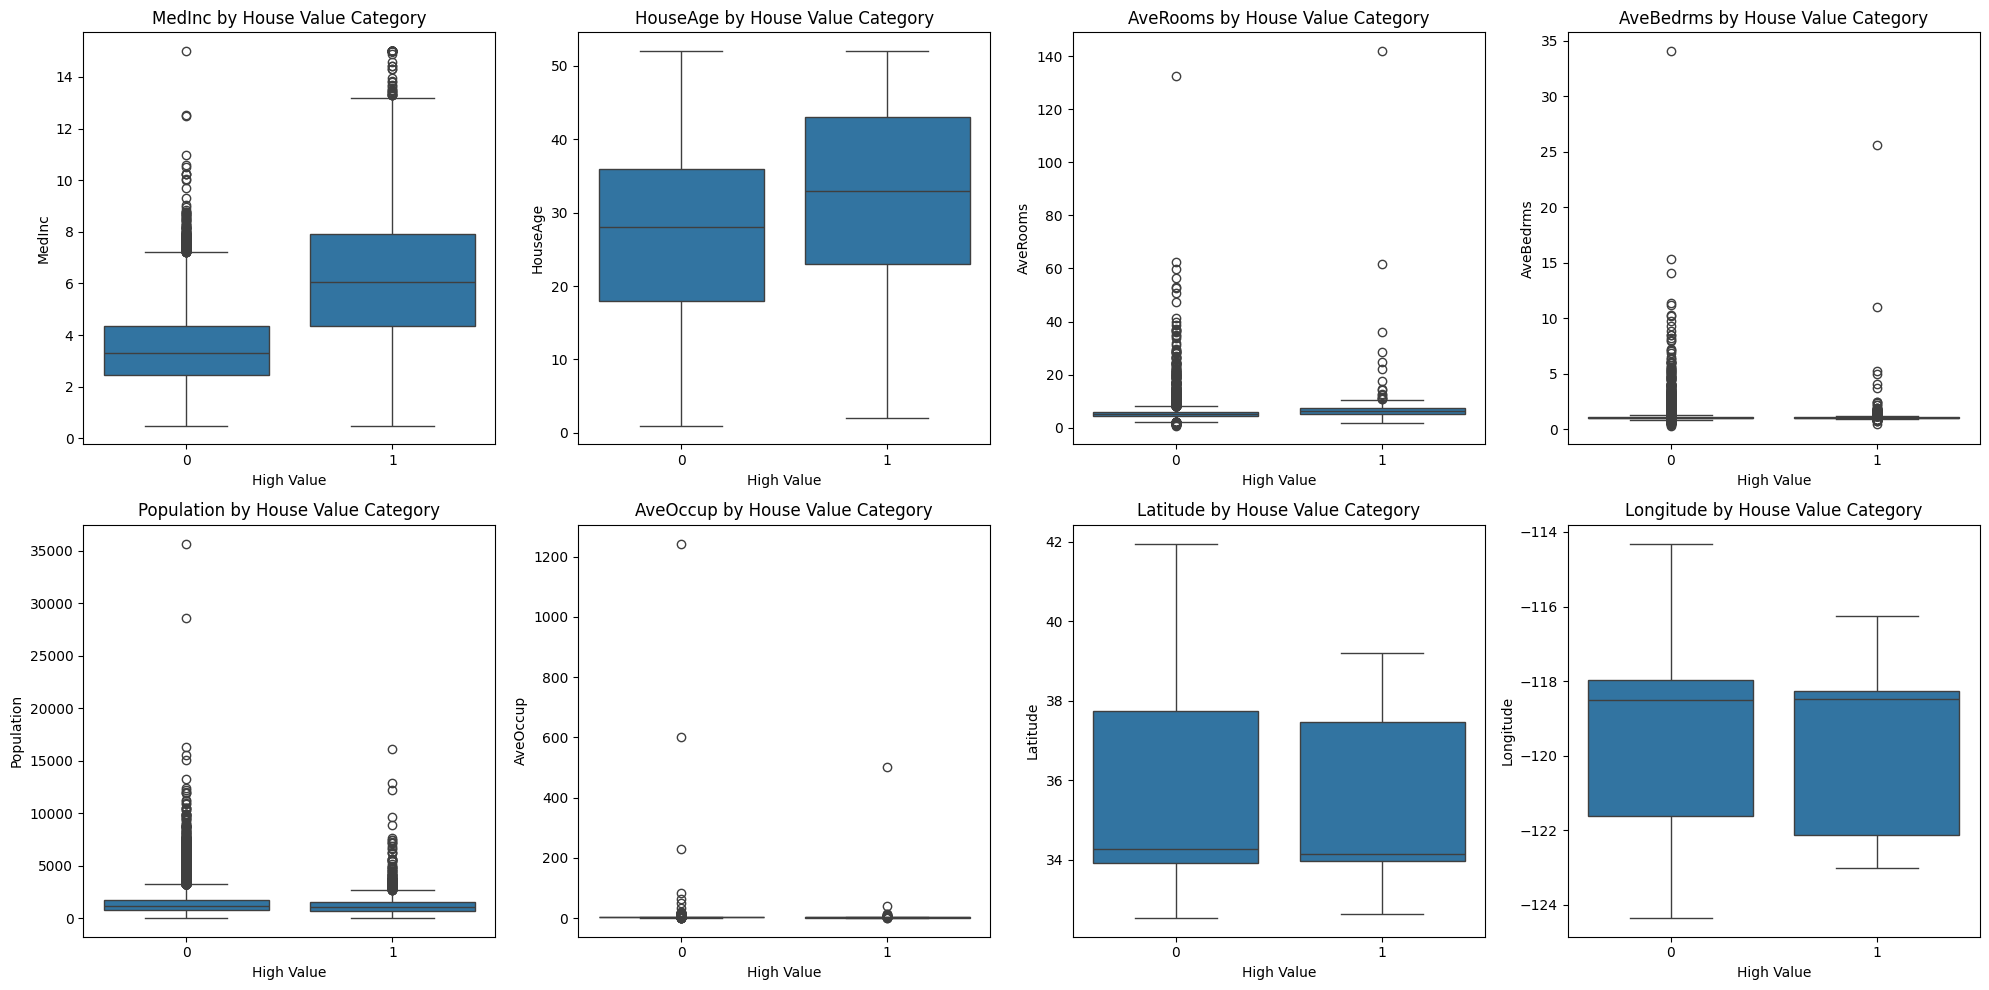

In [ ]:
# Create binary classification: high_value houses
high_value_threshold = 3.5
high_value = (data.MedHouseVal >= high_value_threshold).astype(int)
data['high_value'] = high_value

print(f"High value houses: {high_value.sum()} ({high_value.mean()*100:.1f}%)")
print(f"Regular value houses: {(1-high_value).sum()} ({(1-high_value).mean()*100:.1f}%)")


### Step 6: Feature Analysis with Box Plots

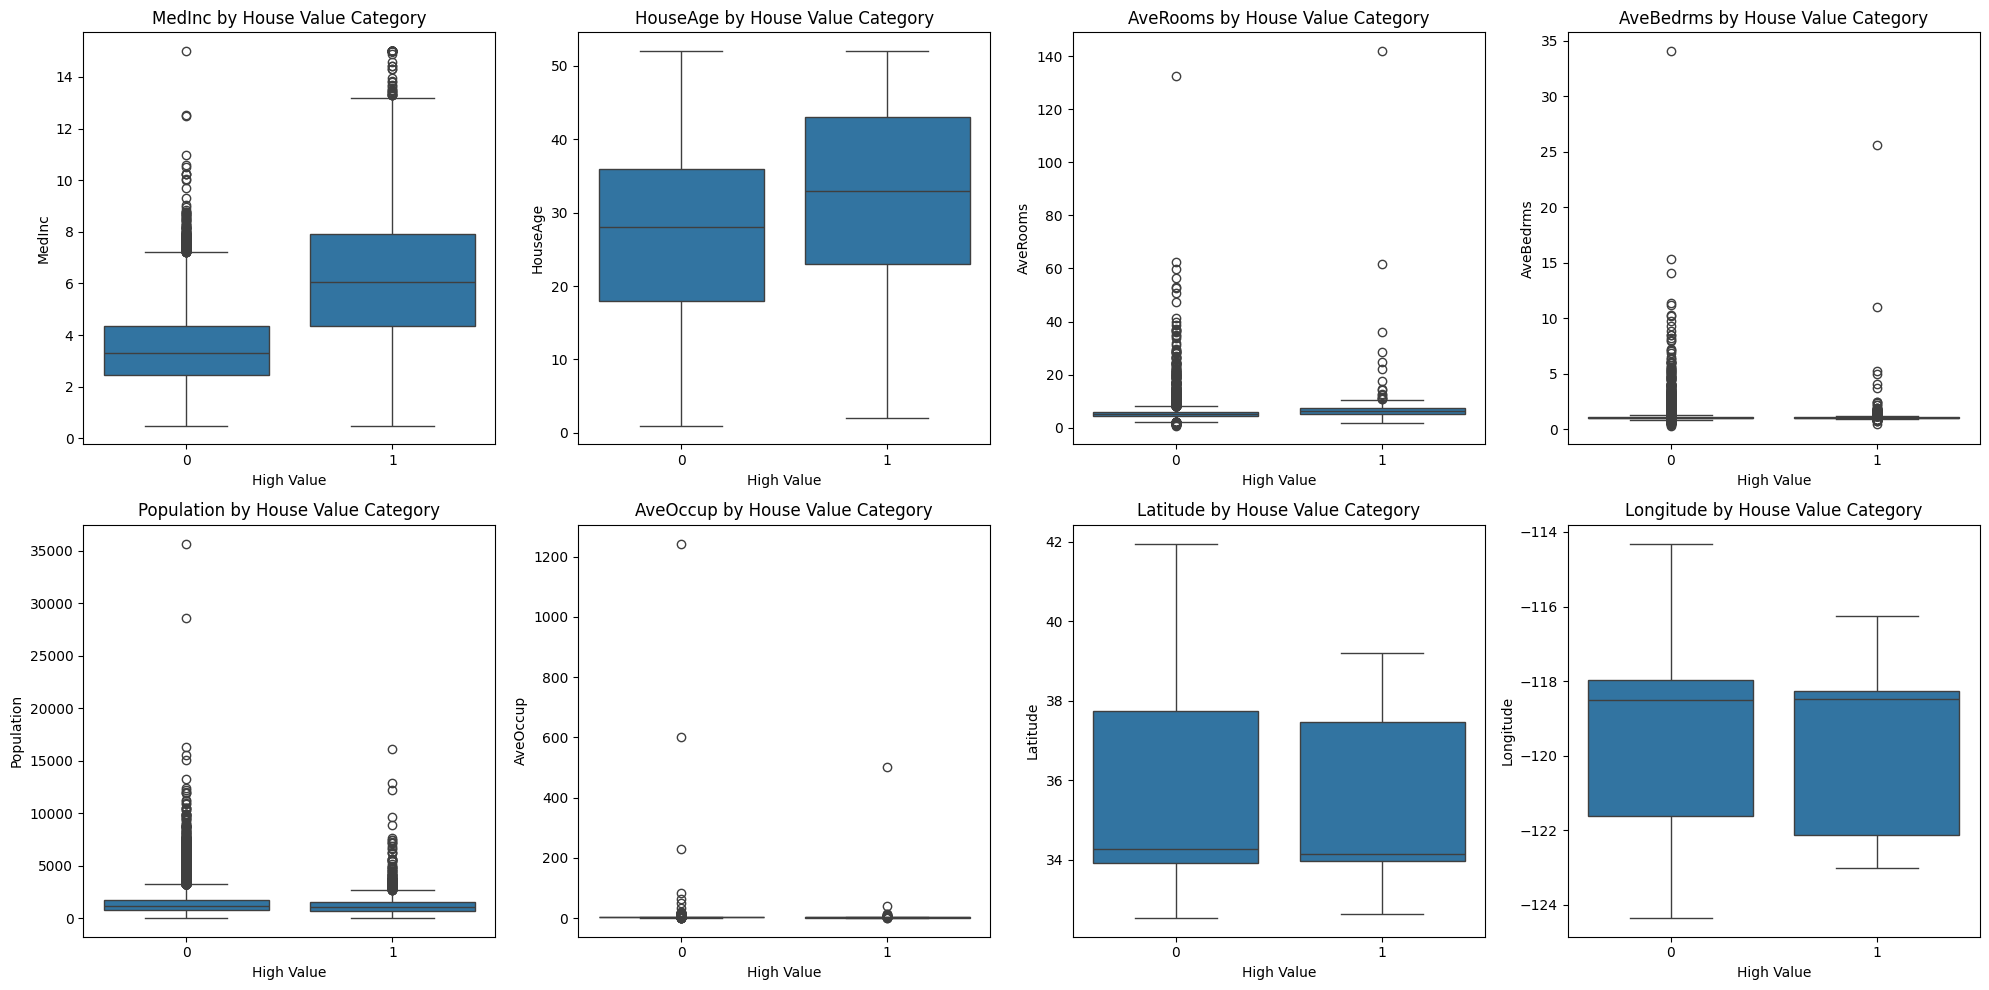

In [8]:
import matplotlib.pyplot as plt

dims = (2, 4)
f, axes = plt.subplots(dims[0], dims[1], figsize=(20, 10))
axis_i, axis_j = 0, 0

feature_cols = housing.feature_names
for col in feature_cols:
    if axis_i < dims[0]:
        sns.boxplot(x=high_value, y=data[col], ax=axes[axis_i, axis_j])
        axes[axis_i, axis_j].set_xlabel('High Value')
        axes[axis_i, axis_j].set_title(f'{col} by House Value Category')
        axis_j += 1
        if axis_j == dims[1]:
            axis_i += 1
            axis_j = 0

plt.tight_layout()
plt.show()

###  Step 7: Feature Engineering

In [9]:
data['rooms_per_person'] = data['AveRooms'] / data['AveOccup']
data['bedrooms_per_room'] = data['AveBedrms'] / data['AveRooms']
data['people_per_house'] = data['Population'] / data['AveOccup']

print("Engineered features added")
print(f"New shape: {data.shape}")

Engineered features added
New shape: (20640, 13)


### Step 8: Check for missing values

In [10]:
data.isna().any()

MedInc               False
HouseAge             False
AveRooms             False
AveBedrms            False
Population           False
AveOccup             False
Latitude             False
Longitude            False
MedHouseVal          False
high_value           False
rooms_per_person     False
bedrooms_per_room    False
people_per_house     False
dtype: bool

### Step 9: Data Splitting

In [11]:
from sklearn.model_selection import train_test_split

X = data.drop(['MedHouseVal', 'high_value'], axis=1)
y = data.high_value

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (12384, 11)
Validation set: (4128, 11)
Test set: (4128, 11)


### Step 10: Build Baseline Model with Gradient Boosting

In [12]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle

# Wrapper for probability predictions
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:, 1]

# Set experiment
mlflow.set_experiment("housing_price_classification")

# Train baseline Gradient Boosting model
with mlflow.start_run(run_name='baseline_gradient_boosting'):
    # Model parameters
    n_estimators = 100
    max_depth = 5
    learning_rate = 0.1
    
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=123
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions_test = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, predictions_test)
    
    # Log parameters
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_param('max_depth', max_depth)
    mlflow.log_param('learning_rate', learning_rate)
    
    # Log metrics
    mlflow.log_metric('auc', auc_score)
    
    print(f"Baseline AUC: {auc_score:.4f}")
    
    # Wrap and log model
    wrappedModel = SklearnModelWrapper(model)
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
    
    conda_env = _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=[
            f"cloudpickle=={cloudpickle.__version__}",
            f"scikit-learn=={sklearn.__version__}"
        ],
        additional_conda_channels=None,
    )
    
    mlflow.pyfunc.log_model(
        "gradient_boosting_model",
        python_model=wrappedModel,
        conda_env=conda_env,
        signature=signature
    )


/Users/samhita/Documents/GitHub/mlops-labs/Experiment_Tracking_Labs/Mlflow_Labs/mlflow_env/lib/python3.11/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2025/11/14 03:25:19 INFO mlflow.tracking.fluent: Experiment with name 'housing_price_classification' does not exist. Creating a new experiment.
2025/11/14 03:25:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Baseline AUC: 0.9664


### Step 11: Feature Importance Analysis

In [13]:
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index=X_train.columns.tolist(),
    columns=['importance']
)
feature_importances.sort_values('importance', ascending=False)


,importance
MedInc,0.468743
Latitude,0.117245
Longitude,0.097677
AveOccup,0.081513
HouseAge,0.071457
rooms_per_person,0.070912
bedrooms_per_room,0.022520
AveBedrms,0.020952
AveRooms,0.018046
people_per_house,0.017856


### Step 12: Register Model in MLflow

In [14]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "baseline_gradient_boosting"').iloc[0].run_id
print(f"Run ID: {run_id}")


Run ID: 8a8246e5f4ab4f71abca9f2bc59673fe


### Step 13: Register Model

In [15]:
model_name = "housing_classifier"
model_version = mlflow.register_model(f"runs:/{run_id}/gradient_boosting_model", model_name)

# Registering the model takes a few seconds
time.sleep(15)


Successfully registered model 'housing_classifier'.
2025/11/14 03:25:33 WARNING mlflow.tracking._model_registry.fluent: Run with id 8a8246e5f4ab4f71abca9f2bc59673fe has no artifacts at artifact path 'gradient_boosting_model', registering model based on models:/m-d3f70d3796564ffc8509207186e8e1ba instead
Created version '1' of model 'housing_classifier'.


### Step 14: Transition to Production

In [16]:
from mlflow.tracking import MlflowClient
client = MlflowClient()

client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Production",
)

print(f"Model {model_name} version {model_version.version} transitioned to Production")


Model housing_classifier version 1 transitioned to Production


### Step 15: Load and Test Production Model

In [17]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test)):.4f}')


AUC: 0.9664


### Step 16: Hyperparameter Optimization with Hyperopt

In [18]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from sklearn.ensemble import GradientBoostingClassifier
import mlflow.sklearn

# Define search space for Gradient Boosting
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0)
}


### Step 17: Define Training Function for Hyperopt

In [19]:
def train_model(params):
    mlflow.sklearn.autolog()
    with mlflow.start_run(nested=True):
        # Create and train model
        gb_model = GradientBoostingClassifier(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            subsample=params['subsample'],
            random_state=123
        )
        
        gb_model.fit(X_train, y_train)
        
        # Evaluate
        validation_predictions = gb_model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, validation_predictions)
        
        mlflow.log_metric('auc', auc_score)
        
        # Log model
        signature = infer_signature(X_train, gb_model.predict_proba(X_train)[:, 1])
        mlflow.sklearn.log_model(gb_model, "model", signature=signature)
        
        # Return loss (negative AUC to maximize)
        return {'status': STATUS_OK, 'loss': -1*auc_score}


### Step 18: Run Hyperparameter Optimization

In [20]:
trials = Trials()

with mlflow.start_run(run_name='gradient_boosting_hyperopt'):
    best_params = fmin(
        fn=train_model,
        space=search_space,
        algo=tpe.suggest,
        max_evals=20,  # Reduced for faster execution
        trials=trials,
    )
    
print(f"Best parameters: {best_params}")


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

2025/11/14 03:26:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  5%|▌         | 1/20 [00:09<03:04,  9.73s/trial, best loss: -0.9436468821500951]

2025/11/14 03:26:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 10%|█         | 2/20 [00:21<03:20, 11.14s/trial, best loss: -0.9572890937217671]

2025/11/14 03:26:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 15%|█▌        | 3/20 [00:26<02:20,  8.26s/trial, best loss: -0.9572890937217671]

2025/11/14 03:26:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 20%|██        | 4/20 [00:40<02:48, 10.54s/trial, best loss: -0.957693307397965] 

2025/11/14 03:27:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 25%|██▌       | 5/20 [00:53<02:49, 11.31s/trial, best loss: -0.957693307397965]

2025/11/14 03:27:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 30%|███       | 6/20 [00:59<02:13,  9.53s/trial, best loss: -0.9593237364426281]

2025/11/14 03:27:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 35%|███▌      | 7/20 [01:06<01:53,  8.71s/trial, best loss: -0.9593237364426281]

2025/11/14 03:27:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 40%|████      | 8/20 [01:14<01:42,  8.57s/trial, best loss: -0.9611356594389172]

2025/11/14 03:27:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 45%|████▌     | 9/20 [01:19<01:20,  7.29s/trial, best loss: -0.9611356594389172]

2025/11/14 03:27:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 50%|█████     | 10/20 [01:31<01:28,  8.81s/trial, best loss: -0.9611356594389172]

2025/11/14 03:27:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 55%|█████▌    | 11/20 [01:36<01:08,  7.59s/trial, best loss: -0.9611356594389172]

2025/11/14 03:27:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 60%|██████    | 12/20 [01:44<01:02,  7.87s/trial, best loss: -0.9611356594389172]

2025/11/14 03:28:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 65%|██████▌   | 13/20 [01:53<00:56,  8.06s/trial, best loss: -0.9611356594389172]

2025/11/14 03:28:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 70%|███████   | 14/20 [02:01<00:47,  7.97s/trial, best loss: -0.9611356594389172]

2025/11/14 03:28:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 75%|███████▌  | 15/20 [02:15<00:49,  9.83s/trial, best loss: -0.9611356594389172]

2025/11/14 03:28:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 80%|████████  | 16/20 [02:24<00:38,  9.66s/trial, best loss: -0.9611356594389172]

2025/11/14 03:28:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 85%|████████▌ | 17/20 [02:36<00:31, 10.37s/trial, best loss: -0.9611356594389172]

2025/11/14 03:28:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 90%|█████████ | 18/20 [02:43<00:18,  9.44s/trial, best loss: -0.9611356594389172]

2025/11/14 03:29:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 95%|█████████▌| 19/20 [02:53<00:09,  9.44s/trial, best loss: -0.9611356594389172]

2025/11/14 03:29:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



100%|██████████| 20/20 [02:57<00:00,  8.87s/trial, best loss: -0.9611356594389172]
Best parameters: {'learning_rate': np.float64(0.05810244988078954), 'max_depth': np.float64(9.0), 'min_samples_leaf': np.float64(9.0), 'min_samples_split': np.float64(10.0), 'n_estimators': np.float64(100.0), 'subsample': np.float64(0.8267540457742891)}


### Step 19: Find Best Run

In [21]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]:.4f}')


AUC of Best Run: 0.9664


### Step 20: Update Production Model

In [22]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import mlflow.sklearn

print("="*60)
print("TRAINING MULTIPLE MODELS FOR COMPARISON")
print("="*60)
with mlflow.start_run(run_name='random_forest_comparison'):
    print("\n Training Random Forest...")
    
    rf_model = RandomForestClassifier(
        n_estimators=150,
        max_depth=8,
        min_samples_split=5,
        random_state=123,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, rf_predictions)
    
    mlflow.log_param('model_type', 'RandomForest')
    mlflow.log_param('n_estimators', 150)
    mlflow.log_param('max_depth', 8)
    mlflow.log_metric('test_auc', rf_auc)
    
    signature = infer_signature(X_train, rf_model.predict_proba(X_train)[:, 1])
    mlflow.sklearn.log_model(rf_model, "model", signature=signature)
    
    print(f"Random Forest AUC: {rf_auc:.4f}")
    rf_run_id = mlflow.active_run().info.run_id

TRAINING MULTIPLE MODELS FOR COMPARISON

 Training Random Forest...


2025/11/14 03:30:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Random Forest AUC: 0.9530


In [23]:
with mlflow.start_run(run_name='adaboost_comparison'):
    print("\n Training AdaBoost...")
    
    ada_model = AdaBoostClassifier(
        n_estimators=100,
        learning_rate=0.5,
        random_state=123
    )
    
    ada_model.fit(X_train, y_train)
    ada_predictions = ada_model.predict_proba(X_test)[:, 1]
    ada_auc = roc_auc_score(y_test, ada_predictions)
    
    mlflow.log_param('model_type', 'AdaBoost')
    mlflow.log_param('n_estimators', 100)
    mlflow.log_param('learning_rate', 0.5)
    mlflow.log_metric('test_auc', ada_auc)
    
    signature = infer_signature(X_train, ada_model.predict_proba(X_train)[:, 1])
    mlflow.sklearn.log_model(ada_model, "model", signature=signature)
    
    print(f"AdaBoost AUC: {ada_auc:.4f}")
    ada_run_id = mlflow.active_run().info.run_id


 Training AdaBoost...


2025/11/14 03:30:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


AdaBoost AUC: 0.9480


In [24]:
with mlflow.start_run(run_name='logistic_regression_baseline'):
    print("\n Training Logistic Regression (Simple Baseline)...")
    
    lr_model = LogisticRegression(
        max_iter=1000,
        random_state=123,
        solver='liblinear'
    )
    
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict_proba(X_test)[:, 1]
    lr_auc = roc_auc_score(y_test, lr_predictions)
    
    mlflow.log_param('model_type', 'LogisticRegression')
    mlflow.log_param('solver', 'liblinear')
    mlflow.log_metric('test_auc', lr_auc)
    
    signature = infer_signature(X_train, lr_model.predict_proba(X_train)[:, 1])
    mlflow.sklearn.log_model(lr_model, "model", signature=signature)
    
    print(f"Logistic Regression AUC: {lr_auc:.4f}")
    lr_run_id = mlflow.active_run().info.run_id


 Training Logistic Regression (Simple Baseline)...


2025/11/14 03:30:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logistic Regression AUC: 0.9252


### Step 21: Transition New Version to Production

In [25]:
# Register All Models for Comparison

from mlflow.tracking import MlflowClient
client = MlflowClient()

model_name = "housing_classifier"
print("\n" + "="*60)
print("REGISTERING ALL MODELS FOR COMPARISON")
print("="*60)

# Dictionary to store model versions and their metrics
model_versions = {}

# Register the best hyperopt model (from earlier)
try:
    print(f"\n📝 Registering Gradient Boosting (Optimized)...")
    gb_version = mlflow.register_model(
        f"runs:/{best_run.run_id}/model", 
        model_name
    )
    model_versions['GradientBoosting_Optimized'] = {
        'version': gb_version.version,
        'auc': best_run["metrics.auc"],
        'run_id': best_run.run_id
    }
    print(f"✅ Version {gb_version.version}: Gradient Boosting (Optimized) - AUC: {best_run['metrics.auc']:.4f}")
except:
    print("Gradient Boosting already registered")

# Register Random Forest
print(f"\n📝 Registering Random Forest...")
rf_version = mlflow.register_model(
    f"runs:/{rf_run_id}/model", 
    model_name
)
model_versions['RandomForest'] = {
    'version': rf_version.version,
    'auc': rf_auc,
    'run_id': rf_run_id
}
print(f"✅ Version {rf_version.version}: Random Forest - AUC: {rf_auc:.4f}")

# Register AdaBoost
print(f"\n📝 Registering AdaBoost...")
ada_version = mlflow.register_model(
    f"runs:/{ada_run_id}/model", 
    model_name
)
model_versions['AdaBoost'] = {
    'version': ada_version.version,
    'auc': ada_auc,
    'run_id': ada_run_id
}
print(f"✅ Version {ada_version.version}: AdaBoost - AUC: {ada_auc:.4f}")

# Register Logistic Regression
print(f"\n📝 Registering Logistic Regression...")
lr_version = mlflow.register_model(
    f"runs:/{lr_run_id}/model", 
    model_name
)
model_versions['LogisticRegression'] = {
    'version': lr_version.version,
    'auc': lr_auc,
    'run_id': lr_run_id
}
print(f"✅ Version {lr_version.version}: Logistic Regression - AUC: {lr_auc:.4f}")

time.sleep(10)  # Wait for registration

Registered model 'housing_classifier' already exists. Creating a new version of this model...
Registered model 'housing_classifier' already exists. Creating a new version of this model...
2025/11/14 03:30:46 WARNING mlflow.tracking._model_registry.fluent: Run with id 46fcf4a8a3aa4036a26e47a1396744dd has no artifacts at artifact path 'model', registering model based on models:/m-042c9f080c2846879ecf2acba1d4e8a6 instead
Created version '2' of model 'housing_classifier'.
Registered model 'housing_classifier' already exists. Creating a new version of this model...
2025/11/14 03:30:46 WARNING mlflow.tracking._model_registry.fluent: Run with id fed2da6af07547158668aed00e0cabfa has no artifacts at artifact path 'model', registering model based on models:/m-5ff5502d43ec41c6801a93e0af2b5395 instead



REGISTERING ALL MODELS FOR COMPARISON

📝 Registering Gradient Boosting (Optimized)...
Gradient Boosting already registered

📝 Registering Random Forest...
✅ Version 2: Random Forest - AUC: 0.9530

📝 Registering AdaBoost...
✅ Version 3: AdaBoost - AUC: 0.9480

📝 Registering Logistic Regression...


Created version '3' of model 'housing_classifier'.
Registered model 'housing_classifier' already exists. Creating a new version of this model...
2025/11/14 03:30:46 WARNING mlflow.tracking._model_registry.fluent: Run with id 5b88fff34ee240d08ac84d037e7a4c24 has no artifacts at artifact path 'model', registering model based on models:/m-e135f8d8227c458ab176bc2b14061821 instead
Created version '4' of model 'housing_classifier'.


✅ Version 4: Logistic Regression - AUC: 0.9252


### Step 22: Test New Production Model

In [26]:
import pandas as pd

print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)

# Create comparison dataframe
comparison_data = []
for model_type, info in model_versions.items():
    comparison_data.append({
        'Model': model_type,
        'Version': info['version'],
        'AUC': info['auc'],
        'Run ID': info['run_id'][:8] + '...' 
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('AUC', ascending=False)

print("\n📊 Model Performance Ranking:")
print(comparison_df.to_string(index=False))

# Identify best model
best_model = comparison_df.iloc[0]
print(f"\n🏆 Best Model: {best_model['Model']}")
print(f"   Version: {best_model['Version']}")
print(f"   AUC: {best_model['AUC']:.4f}")


MODEL COMPARISON RESULTS

📊 Model Performance Ranking:
             Model  Version      AUC      Run ID
      RandomForest        2 0.953015 46fcf4a8...
          AdaBoost        3 0.948007 fed2da6a...
LogisticRegression        4 0.925174 5b88fff3...

🏆 Best Model: RandomForest
   Version: 2
   AUC: 0.9530


In [ ]:
# Stage Management
print("\n" + "="*60)
print("ASSIGNING MODEL STAGES")
print("="*60)

# Get the best model version number
best_version = comparison_df.iloc[0]['Version']
second_best_version = comparison_df.iloc[1]['Version']

# Assign stages based on performance
print("\n Stage Assignments:")

# Best model → Production
client.transition_model_version_stage(
    name=model_name,
    version=best_version,
    stage="Production"
)
print(f"✅ Version {best_version} → Production (Best Model)")

# Second best → Staging
client.transition_model_version_stage(
    name=model_name,
    version=second_best_version,
    stage="Staging"
)
print(f"✅ Version {second_best_version} → Staging (Second Best)")

# Others → Archived
for _, row in comparison_df.iloc[2:].iterrows():
    client.transition_model_version_stage(
        name=model_name,
        version=row['Version'],
        stage="Archived"
    )
    print(f"📦 Version {row['Version']} → Archived")


ASSIGNING MODEL STAGES

 Stage Assignments:
✅ Version 2 → Production (Best Model)
✅ Version 3 → Staging (Second Best)
📦 Version 4 → Archived


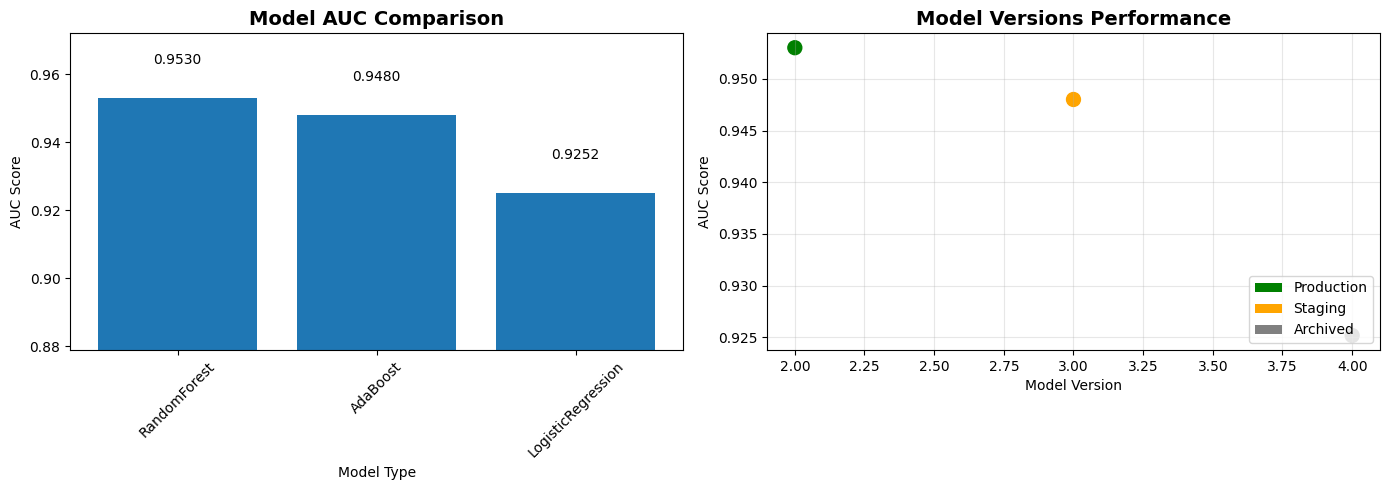


✅ Model comparison complete!
📊 Total models trained and registered: 3
🚀 Production model: RandomForest (Version 2)


In [ ]:
# Visual Comparison of Models

import matplotlib.pyplot as plt

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of AUC scores
axes[0].bar(comparison_df['Model'], comparison_df['AUC'])
axes[0].set_title('Model AUC Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model Type')
axes[0].set_ylabel('AUC Score')
axes[0].set_ylim([comparison_df['AUC'].min() * 0.95, comparison_df['AUC'].max() * 1.02])
for i, v in enumerate(comparison_df['AUC']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center')
axes[0].tick_params(axis='x', rotation=45)

# Model version timeline
versions_df = comparison_df.sort_values('Version')
colors = ['green' if v == best_version else 'orange' if v == second_best_version else 'gray' 
          for v in versions_df['Version']]
axes[1].scatter(versions_df['Version'], versions_df['AUC'], c=colors, s=100)
axes[1].set_title('Model Versions Performance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Model Version')
axes[1].set_ylabel('AUC Score')
axes[1].grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Production'),
    Patch(facecolor='orange', label='Staging'),
    Patch(facecolor='gray', label='Archived')
]
axes[1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("\n✅ Model comparison complete!")
print(f"📊 Total models trained and registered: {len(model_versions)}")
print(f"🚀 Production model: {best_model['Model']} (Version {best_version})")

In [ ]:
# Test Production vs Staging Models
print("\n" + "="*60)
print("TESTING PRODUCTION VS STAGING MODELS")
print("="*60)

# Load and test Production model
prod_model = mlflow.pyfunc.load_model(f"models:/{model_name}/Production")
prod_predictions = prod_model.predict(X_test[:100])  # Test on subset
prod_auc_sample = roc_auc_score(y_test[:100], prod_predictions)

# Load and test Staging model
staging_model = mlflow.pyfunc.load_model(f"models:/{model_name}/Staging")
staging_predictions = staging_model.predict(X_test[:100])
staging_auc_sample = roc_auc_score(y_test[:100], staging_predictions)

print(f"\n🚀 Production Model Performance (sample): {prod_auc_sample:.4f}")
print(f"📦 Staging Model Performance (sample): {staging_auc_sample:.4f}")
print(f"Δ Difference: {abs(prod_auc_sample - staging_auc_sample):.4f}")

# Show how to serve different versions
print("\n" + "="*60)
print("SERVING COMMANDS FOR DIFFERENT VERSIONS")
print("="*60)
print("\n# Serve Production Model:")
print(f"mlflow models serve --env-manager=local -m models:/{model_name}/Production -p 5001")
print("\n# Serve Staging Model:")
print(f"mlflow models serve --env-manager=local -m models:/{model_name}/Staging -p 5002")
print("\n# Serve Specific Version:")
print(f"mlflow models serve --env-manager=local -m models:/{model_name}/{best_version} -p 5003")


TESTING PRODUCTION VS STAGING MODELS

🚀 Production Model Performance (sample): 0.8636
📦 Staging Model Performance (sample): 0.9167
Δ Difference: 0.0530

SERVING COMMANDS FOR DIFFERENT VERSIONS

# Serve Production Model:
mlflow models serve --env-manager=local -m models:/housing_classifier/Production -p 5001

# Serve Staging Model:
mlflow models serve --env-manager=local -m models:/housing_classifier/Staging -p 5002

# Serve Specific Version:
mlflow models serve --env-manager=local -m models:/housing_classifier/2 -p 5003


### Step 23: Serve Model (run in terminal)

In [ ]:
# mlflow models serve --env-manager=local -m models:/housing_classifier/production -h 0.0.0.0 -p 5001


### Step 24: Test API Endpoint

In [ ]:
import requests
import json

# Prepare test data
test_sample = X_test.iloc[:5]  # Take first 5 samples

url = 'http://localhost:5001/invocations'
data_dict = {"dataframe_split": test_sample.to_dict(orient='split')}

# Note: Run this after starting the model server in a separate terminal
try:
    response = requests.post(url, json=data_dict)
    if response.status_code == 200:
        predictions = response.json()
        print("API Predictions:", predictions)
    else:
        print(f"Error: {response.status_code}")
except requests.exceptions.ConnectionError:
    print("Model server not running. Start it with:")
    print("mlflow models serve --env-manager=local -m models:/housing_classifier/production -h 0.0.0.0 -p 5001")


API Predictions: {'predictions': [0.005125287048604028, 0.006299858012752273, 0.005240679807911696, 0.8532004920970161, 0.009089412778726113]}


### Step 25: View MLflow UI

In [35]:
!mlflow ui --port=5001

/Users/samhita/Documents/GitHub/mlops-labs/Experiment_Tracking_Labs/Mlflow_Labs/mlflow_env/lib/python3.11/site-packages/mlflow/server/handlers.py:256: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, artifact_uri)
/Users/samhita/Documents/GitHub/mlops-labs/Experiment_Tracking_Labs/Mlflow_Labs/mlflow_env/lib/python3.11/site-packages/mlflow/server/handlers.py:285: FutureWarning: Filesystem model registry backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri)
[MLflow] Security middleware enabled with default settings (localhost-only). To allow connections from other hosts, use --host 0.0.0.0 and configure --allowed-hosts and --cors-allowed-origins.
INFO:  